# Has Alpha

In strategy 9, triples of coins that become sufficiently uncorrelated are just removed from the portfolio, even if there was an open position with them, potentially resulting in a large net loss by not waiting for the triple to revert to its mean.

In [7]:
# Historical snapshot of coins from December 01, 2019: https://coinmarketcap.com/historical/20191201/ used to
# get a representative set of coins from before the period of analysis to avoid look-ahead bias.

strat_univ = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT',
    'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LINKUSDT', 'ATOMUSDT',
    'NEOUSDT', 'MKRUSDT', 'DASHUSDT', 'ETCUSDT', 'USDCUSDT', 'ONTUSDT', 'VETUSDT',
    'DOGEUSDT', 'BATUSDT', 'ZECUSDT',
    'SNXUSDT', 'QTUMUSDT', 'TUSDUSDT', 'ZRXUSDT',
    'THXUSDT', 'THRUSDT', 'ALGOUSDT', 'REPUSDT', 'NANOUSDT', 'KBCUSDT', 'BTGUSDT', 'RVNUSDT', 'OMGUSDT',
    'CNXUSDT', 'ABBCUSDT', 'XINUSDT', 'VSYSUSDT', 'SEELEUSDT', 'EONUSDT', 'ZBUSDT', 'EKTUSDT', 'DGBUSDT',
    'BTMUSDT', 'LSKUSDT', 'KMDUSDT', 'SAIUSDT', 'LUNAUSDT', 'KCSUSDT', 'FTTUSDT', 'QNTUSDT', 'SXPUSDT',
    'BDXUSDT', 'GAPUSDT', 'BCDUSDT', 'THETAUSDT', 'ICXUSDT', 'FSTUSDT', 'MATICUSDT', 'SCUSDT', 'EVRUSDT',
    'BTTUSDT', 'MOFUSDT', 'IOSTUSDT', 'MCOUSDT', 'WAVESUSDT', 'XVGUSDT', 'MONAUSDT', 'BTSUSDT', 'BCNUSDT',
    'HCUSDT', 'MAIDUSDT', 'NEXOUSDT', 'ARDRUSDT', 'DXUSDT', 'OKBUSDT', 'FXCUSDT', 'RLCUSDT', 'MBUSDT',
    'BXKUSDT', 'AEUSDT', 'ENJUSDT', 'STEEMUSDT', 'SLVUSDT', 'BRZEUSDT', 'ZILUSDT', 'VESTUSDT', 'ZENUSDT',
    'SOLVEUSDT', 'CHZUSDT', 'NOAHUSDT', 'LAUSDT', 'BTMXUSDT', 'ETNUSDT', 'ENGUSDT', 'ILCUSDT', 'NPXSUSDT',
    'CRPTUSDT', 'GNTUSDT', 'SNTUSDT', 'ELFUSDT', 'JWLUSDT', 'FETUSDT', 'BOTXUSDT', 'NRGUSDT', 'DGDUSDT',
    'EXMRUSDT', 'EURSUSDT', 'AOAUSDT', 'RIFUSDT', 'CIX100USDT', 'BFUSDT', 'XZCUSDT', 'FABUSDT', 'GRINUSDT',
    'NETUSDT', 'VERIUSDT', 'DGTXUSDT', 'KNCUSDT', 'RENUSDT', 'STRATUSDT', 'ETPUSDT', 'NEXUSDT', 'NEWUSDT',
    'BCZEROUSDT', 'GXCUSDT', 'TNTUSDT', 'BTC2USDT', 'PPTUSDT', 'USDKUSDT', 'ELAUSDT', 'IGNISUSDT', 'PLCUSDT',
    'BNKUSDT', 'DTRUSDT', 'RCNUSDT', 'HPTUSDT', 'LAMBUSDT', 'MANAUSDT', 'EDCUSDT', 'BEAMUSDT', 'TTUSDT',
    'AIONUSDT', 'BZUSDT', 'WTCUSDT', 'WICCUSDT', 'LRCUSDT', 'BRDUSDT', 'FCTUSDT', 'NULSUSDT', 'FTMUSDT',
    'IOTXUSDT', 'QBITUSDT', 'XMXUSDT', 'YOUUSDT', 'NASUSDT', 'WAXPUSDT', 'ARKUSDT', 'RDDUSDT', 'GNYUSDT',
    'AGVCUSDT', 'HYNUSDT', 'CVCUSDT', 'WANUSDT', 'WINUSDT', 'LINAUSDT', 'RUSDT', 'PAIUSDT', 'FSNUSDT',
    'FUNUSDT', 'DPTUSDT', 'BHDUSDT', 'LOOMUSDT', 'XACUSDT', 'BUSDUSDT', 'BHPUSDT', 'TRUEUSDT', 'LOKIUSDT',
    'QASHUSDT', 'BNTUSDT', 'DOTUSDT', 'SOLUSDT']

## Load And Structure Data

In [8]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
# in_sample_end = pd.to_datetime("2022-12-31 20:00:00")
# out_sample_start = pd.to_datetime("2023-01-01 00:00:00")

In [10]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for XRPUSDT.
Downloaded data for BCHUSDT.
Downloaded data for LTCUSDT.
Downloaded data for EOSUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XLMUSDT.
Downloaded data for TRXUSDT.
Downloaded data for ADAUSDT.
Downloaded data for XTZUSDT.
Downloaded data for LINKUSDT.
Downloaded data for ATOMUSDT.
Downloaded data for NEOUSDT.
Downloaded data for MKRUSDT.
Downloaded data for DASHUSDT.
Downloaded data for ETCUSDT.
Downloaded data for USDCUSDT.
Downloaded data for ONTUSDT.
Downloaded data for VETUSDT.
Downloaded data for DOGEUSDT.
Downloaded data for BATUSDT.
Downloaded data for ZECUSDT.
Downloaded data for SNXUSDT.
Downloaded data for QTUMUSDT.
Downloaded data for TUSDUSDT.
Downloaded data for ZRXUSDT.
Couldn't load data for THXUSDT.
Couldn't load data for THRUSDT.
Downloaded data for ALGOUSDT.
Couldn't load data for REPUSDT.
Couldn't load data for NANOUSDT.
Couldn't load data for KBCUSDT.
Couldn't load data 

In [11]:
px_close = {coin: px_data[coin]["close"] for coin in px_data}
px_close = pd.DataFrame(px_close).astype(float)
px_close.index.rename("datetime", inplace=True)

px_close

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,0.19406,205.64,41.58,NaN,13.8159,0.04515,NaN,0.03308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7205.50,130.52,0.19518,206.72,41.55,NaN,13.7648,0.04493,NaN,0.03320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7195.80,130.84,0.19358,205.61,41.67,NaN,13.7162,0.04509,NaN,0.03321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,7233.02,131.84,0.19428,206.63,41.89,NaN,13.7958,0.04542,NaN,0.03357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7223.72,131.98,0.19474,206.35,41.79,NaN,13.7270,0.04547,NaN,0.03361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-16 20:00:00,96204.12,2659.08,2.72840,326.00,125.70,0.5852,674.0000,0.34330,NaN,0.77180,...,0.3264,0.1331,0.5195,0.03217,0.03002,0.047,NaN,0.495,4.870,188.35
2025-02-17 00:00:00,96193.45,2671.29,2.71670,326.70,124.76,0.5852,671.8000,0.34490,NaN,0.79390,...,0.3352,0.1462,0.5304,0.03217,0.03395,0.047,NaN,0.495,4.885,186.71
2025-02-17 04:00:00,96111.59,2678.65,2.65580,327.30,125.18,0.5832,670.1500,0.33640,NaN,0.79450,...,0.3329,0.1316,0.5418,0.03217,0.03400,0.047,NaN,0.495,4.855,181.70


In [12]:
import statsmodels.api as sm
import copy
import numpy as np

z_score_threshold = 2.0
min_data_points_to_transact = 10 * 6
use_min_corr = False
correlation_acceptance_threshold = 0.90
correlation_rejection_threshold = 0.80
# look_back_window_size = 30 * 6
# look_back_min_periods = 10 * 6

def has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, px_close_data,
                                 correlation_acceptance_threshold):
    if np.isnan(px_close_data[coin]).any():
        return False
    num_available_coins = 0
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if (other_coin != coin and (other_coin not in coins_in_a_triple) and \
            (not np.isnan(px_close_data[other_coin]).any())):
            num_available_coins += 1
    return num_available_coins >= 2


def update_correlated_coins_to_min_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        px_close_data, correlation_acceptance_threshold):
    min_corr = 1.0
    min_corr_coin = None
    second_smallest_corr = 1.0
    second_min_corr_coin = None
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if np.isnan(px_close_data[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] <= min_corr:
            second_smallest_corr, min_corr = min_corr, corr_matrix.loc[coin, other_coin]
            second_min_corr_coin, min_corr_coin = min_corr_coin, other_coin
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] <= second_smallest_corr:
            second_smallest_corr = corr_matrix.loc[coin, other_coin]
            second_min_corr_coin = other_coin
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(min_corr_coin)
    coins_in_a_triple.add(second_min_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(0.0, columns=[min_corr_coin, second_min_corr_coin,
                                                                  'alpha', 'residual'],
                                                    index=[])

def update_correlated_coins_to_max_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        px_close_data, correlation_acceptance_threshold):
    max_corr = -1.0
    max_corr_coin = None
    second_largest_corr = 1.0
    second_largest_corr_coin = None
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if np.isnan(px_close_data[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= max_corr:
            second_largest_corr, max_corr = max_corr, corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin, max_corr_coin = max_corr_coin, other_coin
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= second_largest_corr:
            second_largest_corr = corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin = other_coin
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(max_corr_coin)
    coins_in_a_triple.add(second_largest_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(0.0, columns=[max_corr_coin, second_largest_corr_coin,
                                                                  'alpha', 'residual'],
                                                    index=[])


def get_holdings_df(px_close, look_back_min_periods, look_back_window_size, correlation_acceptance_threshold,
                    correlation_rejection_threshold, min_data_points_to_transact, z_score_threshold,
                    use_min_corr):
    holdings_df = pd.DataFrame(0.0, columns=px_close.columns, index=px_close.index)

    current_correlated_triples = dict()
    coins_in_a_triple = set()

    for index in range(look_back_min_periods, len(holdings_df)):
        px_close_window = px_close[max(index-look_back_window_size, 0):index]

        time_index = px_close.index[index]
        holdings_df.loc[time_index] = pd.Series(0.0, index=holdings_df.columns)

        corr_matrix = px_close_window.corr()
        newly_uncorrelated_keys = set()
        for key_coin in current_correlated_triples:
            value_coin_1 = current_correlated_triples[key_coin].columns[0]
            value_coin_2 = current_correlated_triples[key_coin].columns[1]

            triple_list = [key_coin, value_coin_1, value_coin_2]

            if px_close_window[triple_list].iloc[-1].isnull().any():
                newly_uncorrelated_keys.add(key_coin)
            elif ((corr_matrix.loc[key_coin, value_coin_1] < correlation_rejection_threshold or \
                corr_matrix.loc[key_coin, value_coin_2] < correlation_rejection_threshold)):
                newly_uncorrelated_keys.add(key_coin)

        for coin in newly_uncorrelated_keys:
            coins_in_a_triple.remove(coin)
            coins_in_a_triple.remove(current_correlated_triples[coin].columns[0])
            coins_in_a_triple.remove(current_correlated_triples[coin].columns[1])

            if coin in current_correlated_triples: # only the dependent coin will appear as a key
                del current_correlated_triples[coin]

        for coin in holdings_df.columns:
            if ((coin not in coins_in_a_triple) and \
                has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, px_close_window,
                                             correlation_acceptance_threshold) and \
                use_min_corr):
                update_correlated_coins_to_min_corr(coin, corr_matrix, coins_in_a_triple,
                                                    current_correlated_triples, px_close_window,
                                                    correlation_acceptance_threshold)
            elif ((coin not in coins_in_a_triple) and \
                  has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, px_close_window,
                                               correlation_acceptance_threshold) and \
                  (not use_min_corr)):
                update_correlated_coins_to_max_corr(coin, corr_matrix, coins_in_a_triple,
                                                    current_correlated_triples, px_close_window,
                                                    correlation_acceptance_threshold)

        for coin in current_correlated_triples:
            independent_coin_1 = current_correlated_triples[coin].columns[0]
            independent_coin_2 = current_correlated_triples[coin].columns[1]

            model = sm.OLS(px_close_window[coin].iloc[:-1],
                           sm.add_constant(px_close_window[[independent_coin_1, independent_coin_2]].iloc[:-1]))
            result = model.fit()
            result_data = {
                independent_coin_1: result.params[independent_coin_1],
                independent_coin_2: result.params[independent_coin_2],
                'alpha': result.params['const']
            }
            estimate = px_close_window[independent_coin_1].iloc[-1] * result.params[independent_coin_1] + \
                px_close_window[independent_coin_2].iloc[-1] * result.params[independent_coin_2] + \
                result.params['const']
            result_data['residual'] = px_close_window[coin].iloc[-1] - estimate
            result_series = pd.Series(result_data)
            current_correlated_triples[coin].loc[index] = result_series

            if len(current_correlated_triples[coin]) >= min_data_points_to_transact:
                z_score_look_back_len = min(look_back_window_size, len(current_correlated_triples[coin]))
                look_back_coin_regression_data = current_correlated_triples[coin].iloc[(-z_score_look_back_len):]
                residual_mean = look_back_coin_regression_data['residual'].mean()
                residual_std = look_back_coin_regression_data['residual'].std()
                z_score = (result_data['residual'] - residual_mean) / residual_std

                if z_score >= z_score_threshold:
                    holdings_df.loc[time_index, coin] = -1.0
                    holdings_df.loc[time_index, independent_coin_1] = result_data[independent_coin_1]
                    holdings_df.loc[time_index, independent_coin_2] = result_data[independent_coin_2]
                elif z_score <= -z_score_threshold:
                    holdings_df.loc[time_index, coin] = 1.0
                    holdings_df.loc[time_index, independent_coin_1] = -result_data[independent_coin_1]
                    holdings_df.loc[time_index, independent_coin_2] = -result_data[independent_coin_2]
        holdings_df.loc[time_index] = holdings_df.loc[time_index] / holdings_df.loc[time_index].abs().sum()
        
    return holdings_df

In [13]:
def get_net_return(strat_holdings, ret):
    # assume that strat_holdings have already been shifted back in time to avoid look-ahead bias.
    gross_ret = (strat_holdings * ret).sum(axis=1)
    
    turnover = (strat_holdings.fillna(0) - strat_holdings.shift().fillna(0)).abs().sum(axis=1)
    tcost_bps = 20
    return gross_ret.subtract(turnover * tcost_bps * 1e-4, fill_value=0)

In [14]:
import matplotlib.pyplot as plt

def get_net_returns(px_close, holdings_df, plot_title):
    market_returns = px_close / px_close.shift() - 1

    net_returns_ser = get_net_return(holdings_df, market_returns)
    fig = plt.subplots(figsize=(16, 5))
    plt.title(plot_title)
    plt.plot(net_returns_ser.cumsum())
    
    return net_returns_ser

In [15]:
def get_sharpe_ratio_data(net_returns_se):
    sr_data = dict()
    sr_data["total sr"] = net_returns_se.mean() / net_returns_se.std() * np.sqrt(365 * 6)

    out_sample_start = pd.to_datetime("2023-01-01 00:00:00")
    in_sample_end = out_sample_start - pd.Timedelta(hours=4)

    sr_data["in-sample sr"] = net_returns_se.loc[:in_sample_end].mean() / net_returns_se.loc[:in_sample_end].std() * np.sqrt(365 * 6)
    sr_data["out-sample sr"] = net_returns_se.loc[out_sample_start:].mean() / net_returns_se.loc[out_sample_start:].std() * np.sqrt(365 * 6)
    sr_series = pd.Series(sr_data)
    return sr_series

In [16]:
# outcome_df = pd.read_csv("./strat_09a_results.csv", index_col=["z-score", "corr thresholds", "corr priority"])

# outcome_data = dict()
# for triple_index in outcome_df.index:
#     updated_index = (triple_index[0], tuple(map(float, triple_index[1][1:-1].split(','))), triple_index[2])
#     outcome_data[updated_index] = outcome_df.loc[triple_index]

# outcome_data

Note: The time and output from running the following cell for all combinations of parameters that I was interested in trying was excessively large so I ran the cell with each combination sequentially and wrote the output to a csv file to store.

In [17]:
index_selections = []

for z_score_threshold in (1.0, 1.5, 2.0, 2.5, 3.0):
    for correlation_threshold_pair in ((0.9, 0.8), (0.95, 0.90)):
        for use_min_corr in (False, True):
            index_selections.append((z_score_threshold, correlation_threshold_pair, use_min_corr))
index_selections

[(1.0, (0.9, 0.8), False),
 (1.0, (0.9, 0.8), True),
 (1.0, (0.95, 0.9), False),
 (1.0, (0.95, 0.9), True),
 (1.5, (0.9, 0.8), False),
 (1.5, (0.9, 0.8), True),
 (1.5, (0.95, 0.9), False),
 (1.5, (0.95, 0.9), True),
 (2.0, (0.9, 0.8), False),
 (2.0, (0.9, 0.8), True),
 (2.0, (0.95, 0.9), False),
 (2.0, (0.95, 0.9), True),
 (2.5, (0.9, 0.8), False),
 (2.5, (0.9, 0.8), True),
 (2.5, (0.95, 0.9), False),
 (2.5, (0.95, 0.9), True),
 (3.0, (0.9, 0.8), False),
 (3.0, (0.9, 0.8), True),
 (3.0, (0.95, 0.9), False),
 (3.0, (0.95, 0.9), True)]

In [18]:
len(index_selections)

20

##################################################################################

In [66]:
index_selection_index = 2

In [ ]:
z_score_threshold = index_selections[index_selection_index][0]
correlation_acceptance_threshold, correlation_rejection_threshold = index_selections[index_selection_index][1]
use_min_corr = index_selections[index_selection_index][2]

min_data_points_to_transact = 10 * 6

holdings_df = get_holdings_df(px_close, look_back_min_periods, look_back_window_size,
                              correlation_acceptance_threshold, correlation_rejection_threshold,
                              min_data_points_to_transact, z_score_threshold, use_min_corr)
plot_title = f"Cumulative Returns: z_score_threshold = {z_score_threshold}, correlation_thresholds = {(correlation_acceptance_threshold, correlation_rejection_threshold)}, {'MIN CORR' if use_min_corr else 'MAX CORR'}"
net_returns_ser = get_net_returns(px_close, holdings_df, plot_title)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

# current_index = (z_score_threshold, (correlation_acceptance_threshold, correlation_rejection_threshold), "MIN CORR" if use_min_corr else "MAX CORR")
# outcome_data[current_index] = sharpe_ratio_ser

In [68]:
# raw_outcome_data = dict()

# raw_outcome_data[(1.0, (0.9, 0.8), "MAX CORR")] = (-0.697655, -1.655122, 0.722287)
# raw_outcome_data[(1.0, (0.9, 0.8), "MIN CORR")] = (-0.839883, -1.872885, 0.677174)
# raw_outcome_data[(1.0, (0.95, 0.90), "MAX CORR")] = (-0.569846, -1.083777, 0.118578)
# raw_outcome_data[(1.0, (0.95, 0.90), "MIN CORR")] = (-0.910279, -1.356751, -0.222863)
# raw_outcome_data[(1.5, (0.9, 0.8), "MAX CORR")] = (0.671820, -0.769299, 2.676552)
# raw_outcome_data[(1.5, (0.9, 0.8), "MIN CORR")] = (0.117690, -1.291805, 2.006957)
# raw_outcome_data[(1.5, (0.95, 0.90), "MAX CORR")] = (0.057921, -0.867482, 1.295336)
# raw_outcome_data[(1.5, (0.95, 0.90), "MIN CORR")] = (-0.183662, -0.868560, 0.787809)
# raw_outcome_data[(2.0, (0.9, 0.8), "MAX CORR")] = (-0.073871, -1.333163, 1.605784)
# raw_outcome_data[(2.0, (0.9, 0.8), "MIN CORR")] = (0.119271, -1.624664, 2.325721)
# raw_outcome_data[(2.0, (0.95, 0.90), "MAX CORR")] = (0.324721, -0.573805, 1.392854)
# raw_outcome_data[(2.0, (0.95, 0.90), "MIN CORR")] = (0.653827, -0.140204, 1.624076)
# raw_outcome_data[(2.5, (0.9, 0.8), "MAX CORR")] = (0.156169, -1.225710, 2.117413)
# raw_outcome_data[(2.5, (0.9, 0.8), "MIN CORR")] = (0.334605, -1.193888, 2.222129)
# raw_outcome_data[(2.5, (0.95, 0.90), "MAX CORR")] = (0.172363, -0.466989, 0.874054)
# raw_outcome_data[(2.5, (0.95, 0.90), "MIN CORR")] = (0.378919, -0.070759, 0.970634)
# raw_outcome_data[(3.0, (0.9, 0.8), "MAX CORR")] = (-0.092973, -0.785021, 0.759084)
# raw_outcome_data[(3.0, (0.9, 0.8), "MIN CORR")] = (0.305805, -0.326284, 0.977505)
# raw_outcome_data[(3.0, (0.95, 0.90), "MIN CORR")] = (0.419067, 0.513303, 0.292800)
# raw_outcome_data[(3.0, (0.95, 0.90), "MAX CORR")] = (0.238137, 0.021335, 0.504452)

In [69]:
# import pandas as pd

# outcome_df = pd.DataFrame(raw_outcome_data, index=["total sr", "out-sample sr", "in-sample sr"]).transpose()
# outcome_df.index.set_names(["z-score", "corr thresholds", "corr priority"], inplace=True)
# outcome_df

<Axes: xlabel='datetime'>

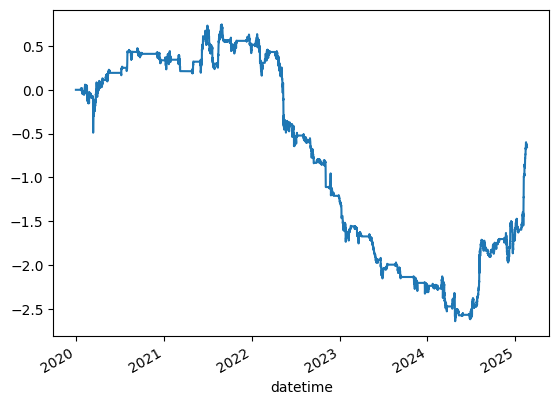

In [70]:
net_returns_ser.cumsum().plot()

In [71]:
# outcome_df.to_csv("./strat_09a_results.csv")

In [72]:
sharpe_ratio_ser

total sr        -0.206988
in-sample sr    -0.680178
out-sample sr    0.442945
dtype: float64

In [73]:
outcome_df = pd.read_csv("./strat_09a_01_results.csv",
                         index_col=["z-score", "corr thresholds", "corr selection method"])
outcome_df

total sr  in-sample sr  \
z-score corr thresholds corr selection method                           
1.0     (0.9, 0.8)      MAX CORR              -0.650743     -1.622978   
                        MIN CORR              -0.252703     -1.256011   

                                               out-sample sr  
z-score corr thresholds corr selection method                 
1.0     (0.9, 0.8)      MAX CORR                    0.841230  
                        MIN CORR                    1.030496

In [74]:
raw_outcome_data = {"total sr": [], "in-sample sr": [], "out-sample sr": []}
indices = []

for (df_index, df_val) in outcome_df.iterrows():
    dict_index = (df_index[0], tuple(map(float, df_index[1][1:-1].split(','))), df_index[2])
    
    indices.append(dict_index)
    raw_outcome_data["total sr"].append(df_val["total sr"])
    raw_outcome_data["in-sample sr"].append(df_val["in-sample sr"])
    raw_outcome_data["out-sample sr"].append(df_val["out-sample sr"])
    
    #dict_val = (df_val["total sr"], df_val["in-sample sr"], df_val["out-sample sr"])
    #raw_outcome_data[dict_index] = dict_val

raw_outcome_data

{'total sr': [-0.6507426991672144, -0.2527025408267335],
 'in-sample sr': [-1.6229778432776298, -1.256010930552529],
 'out-sample sr': [0.841229998195887, 1.0304961438357902]}

In [75]:
tuple_index = (index_selections[index_selection_index][0],
               index_selections[index_selection_index][1],
               "MIN CORR" if index_selections[index_selection_index][2] else "MAX CORR")
# raw_outcome_data[tuple_index] = (sharpe_ratio_ser["total sr"],
#                                  sharpe_ratio_ser["in-sample sr"],
#                                  sharpe_ratio_ser["out-sample sr"])

raw_outcome_data["total sr"].append(sharpe_ratio_ser["total sr"])
raw_outcome_data["in-sample sr"].append(sharpe_ratio_ser["in-sample sr"])
raw_outcome_data["out-sample sr"].append(sharpe_ratio_ser["out-sample sr"])
indices.append(tuple_index)

outcome_df = pd.DataFrame(
    raw_outcome_data,
    index=pd.MultiIndex.from_tuples(indices, names=["z-score", "corr thresholds", "corr selection method"])
)
# outcome_df.index.set_names(["z-score", "corr thresholds", "corr selection method"], inplace=True)
outcome_df

total sr  in-sample sr  \
z-score corr thresholds corr selection method                           
1.0     (0.9, 0.8)      MAX CORR              -0.650743     -1.622978   
                        MIN CORR              -0.252703     -1.256011   
        (0.95, 0.9)     MAX CORR              -0.206988     -0.680178   

                                               out-sample sr  
z-score corr thresholds corr selection method                 
1.0     (0.9, 0.8)      MAX CORR                    0.841230  
                        MIN CORR                    1.030496  
        (0.95, 0.9)     MAX CORR                    0.442945

In [76]:
outcome_df.to_csv("./strat_09a_01_results.csv")

###################################################################

In [25]:
outcome_df = pd.read_csv("./strat_09a_results.csv", index_col=["z-score", "corr thresholds", "corr priority"])
outcome_df

total sr  out-sample sr  in-sample sr
z-score corr thresholds corr priority                                       
1.0     (0.9, 0.8)      MAX CORR      -0.697655      -1.655122      0.722287
                        MIN CORR      -0.839883      -1.872885      0.677174
        (0.95, 0.9)     MAX CORR      -0.569846      -1.083777      0.118578
                        MIN CORR      -0.910279      -1.356751     -0.222863
1.5     (0.9, 0.8)      MAX CORR       0.671820      -0.769299      2.676552
                        MIN CORR       0.117690      -1.291805      2.006957
        (0.95, 0.9)     MAX CORR       0.057921      -0.867482      1.295336
                        MIN CORR      -0.183662      -0.868560      0.787809
2.0     (0.9, 0.8)      MAX CORR      -0.073871      -1.333163      1.605784
                        MIN CORR       0.119271      -1.624664      2.325721
        (0.95, 0.9)     MAX CORR       0.324721      -0.573805      1.392854
                        MIN CORR       0.653827      -0.140204      1.624076
2.5     (0.9, 0.8)      MAX CORR       0.156169      -1.225710      2.117413
                        MIN CORR       0.334605      -1.193888      2.222129
        (0.95, 0.9)     MAX CORR       0.172363      -0.466989      0.874054
                        MIN CORR       0.378919      -0.070759      0.970634
3.0     (0.9, 0.8)      MAX CORR      -0.092973      -0.785021      0.759084
                        MIN CORR       0.305805      -0.326284      0.977505
        (0.95, 0.9)     MIN CORR       0.419067       0.513303      0.292800
                        MAX CORR       0.238137       0.021335      0.504452

Conclusion: z = 3.0, (0.95, 0.9), min-corr selection --> out sample: 0.513303, in sample: 0.292800